# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
# code for these files is at the bottom
!wget --no-verbose -O torch_utils.py https://raw.githubusercontent.com/virtualphoton/ds_utils/b151b2bd4091b767f6b04719d4b04e20a9e4dd19/torch_utils.py
!wget --no-verbose -O plotter.py https://raw.githubusercontent.com/virtualphoton/ds_utils/19a29869699074b02d5dfa76f49b2415c2feac1d/plotter.py
!wget --no-verbose -O magic.py https://raw.githubusercontent.com/virtualphoton/ds_utils/306db2a911cfa245c824c145971c0d8f4d072064/magic.py
!wget --no-verbose -O train.py https://raw.githubusercontent.com/virtualphoton/ds_utils/5c5750bf95fe35c21c758de1a5f5d66e5b75083d/train.py

2023-10-05 12:00:02 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/b151b2bd4091b767f6b04719d4b04e20a9e4dd19/torch_utils.py [1639/1639] -> "torch_utils.py" [1]
2023-10-05 12:00:02 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/19a29869699074b02d5dfa76f49b2415c2feac1d/plotter.py [6238/6238] -> "plotter.py" [1]
2023-10-05 12:00:03 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/306db2a911cfa245c824c145971c0d8f4d072064/magic.py [5604/5604] -> "magic.py" [1]
2023-10-05 12:00:04 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/5c5750bf95fe35c21c758de1a5f5d66e5b75083d/train.py [5443/5443] -> "train.py" [1]


In [2]:
from plotter import History, Plotter, plotly_static
from magic import reprint
from torch_utils import Apply
from train import EarlyStopper

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [4]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [5]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

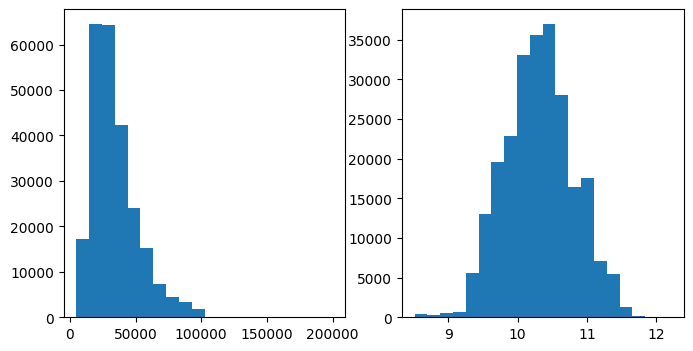

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
30898,68067871,HGV Technician/ Heavy Vehicle Mechanic Theale,HGV Technician/ Heavy Vehicle Mechanic Theale...,Reading Berkshire South East,Reading,NaN,permanent,Excel Technical Resourcing,Other/General Jobs,"From 24,000 to 27,000 per annum",25500,totaljobs.com,10.146473
112061,69688298,Credit Controller,Credit Controller Lincoln A reputable and gro...,Lincoln,Lincoln,NaN,permanent,Lincoln 01522 522101 Grimsby 01472 241019,Accounting & Finance Jobs,16k.00 - 20k.00 pa + bens,18000,jobsite.co.uk,9.798182
61405,68696047,"Junior Sous Chef – Manchester – Luxury Hotel, ...","Junior Sous Chef – Manchester – Luxury Hotel, ...",Manchester Lancashire North West,UK,NaN,permanent,Taste Hospitality Recruitment,Travel Jobs,"Up to 21,000 per annum",21000,totaljobs.com,9.952325


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [9]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col]\
        .astype(str)\
        .str.lower()\
        .apply(tokenizer.tokenize)\
        .apply(' '.join)

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter

# Count how many times does each token occur in both "Title" and "FullDescription" in total

token_counts = Counter([word
                        for line in data[text_columns].values.flatten()
                        for word in line.split()])

In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


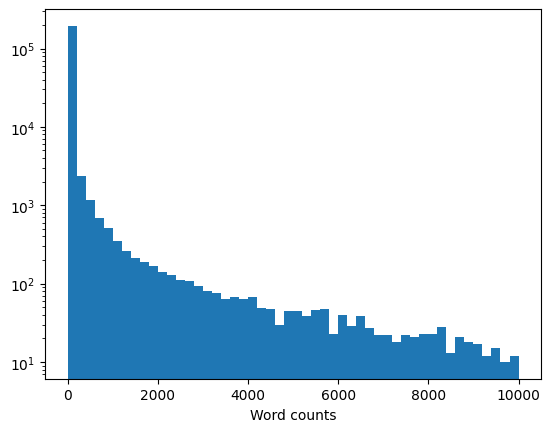

In [13]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [14]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [15]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [16]:
token_to_id = dict(zip(tokens, range(len(tokens))))

In [17]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None, min_len=5):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = max(max_len, min_len)
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [20]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)

data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train: pd.DataFrame
data_val: pd.DataFrame
data_train, data_val  = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


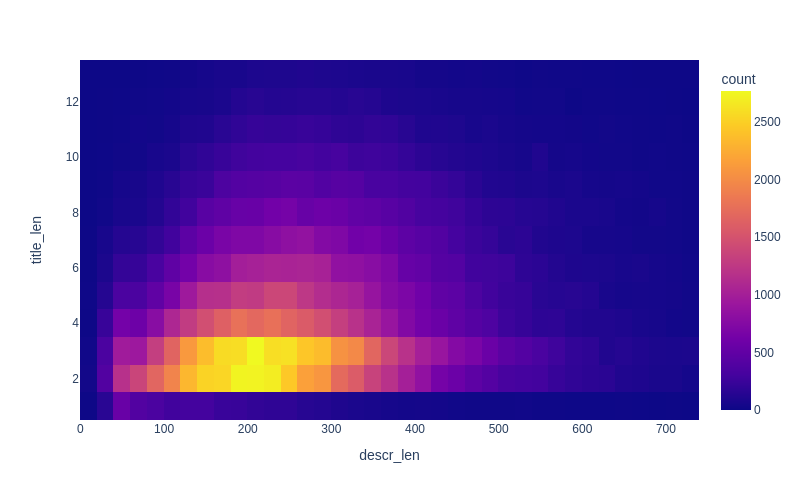

In [22]:
import plotly.express as px
t = pd.DataFrame(dict(
    title_len=data_train.Title.str.split().apply(len),
    descr_len=data_train.FullDescription.str.split().apply(len)
))\
    .query("title_len < title_len.quantile(.99) and descr_len < descr_len.quantile(.99)")
plotly_static(px.density_heatmap(t, x="descr_len", y="title_len", width=800))

In [23]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_tensors(batch: dict, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data: pd.DataFrame, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [24]:
_batch = make_batch(data_train[:3], max_len=10)
_batch

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [40]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        
        self.encoded_len = 64
        outp_features = hid_size*3
        self.title_encoder = nn.Sequential(
            nn.Embedding(n_tokens, self.encoded_len),
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.encoded_len, hid_size, 3),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.description_encoder = nn.Sequential(
            nn.Embedding(n_tokens, self.encoded_len),
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.encoded_len, hid_size, 5, ),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size, bias=False),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(hid_size, hid_size, bias=False)
        )
        self.output = nn.Sequential(
            nn.BatchNorm1d(outp_features),
            nn.ReLU(),
            nn.Linear(outp_features, outp_features, bias=False),
            nn.BatchNorm1d(outp_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(outp_features, 1),
            Apply(torch.squeeze)
        )
        
    def forward(self, batch: dict[str, torch.TensorType]):
        title_enc = self.title_encoder(batch["Title"])
        descr_enc = self.description_encoder(batch["FullDescription"])
        cat_enc = self.cat_encoder(batch["Categorical"])
        concat = torch.cat([title_enc, descr_enc, cat_enc], axis=1)
        return self.output(concat)
    
    def predict(self, batch):
        return self.forward(batch)

In [41]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [42]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [43]:
BATCH_SIZE = 256
EPOCHS = 5

In [44]:
@reprint
def print_metrics(model, data, batch_size=BATCH_SIZE, device=None, **kw):
    if device is None:
        device = device
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return {"mse": mse, "mae": mae}


In [45]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
history = History(drop_query="mse > 1")

In [46]:
stopper = EarlyStopper(model=model, patience=np.inf, save_path="storage/sem_maxpool.pth", bound_history=history,
                       loss="mse")

In [47]:
%%reprint
from math import ceil

EPOCHS = 20
plotter = Plotter(bound_history=history, path="storage/sem_maxpool.png")
torch.cuda.empty_cache()

for epoch in history.range(EPOCHS, stopper, do_tqdm=True):
    model.train()
    for batch in tqdm(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device),
                      total=ceil(len(data_train) / BATCH_SIZE)):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history.push_epoch(print_metrics(model, data_val, device=device))
    plotter.plot()


epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MyOutput()

MyOutput()

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'mse',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'mae',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
               

<a id="1_src" href="#1_dest">to static img</a>

`AdaptiveMaxPooling` doesn't allow to utilize potential of Adam, though the problem of `AdaptiveAvgPooling` + Adam is that its metrics on validation are quite unstable and mse is bigger:
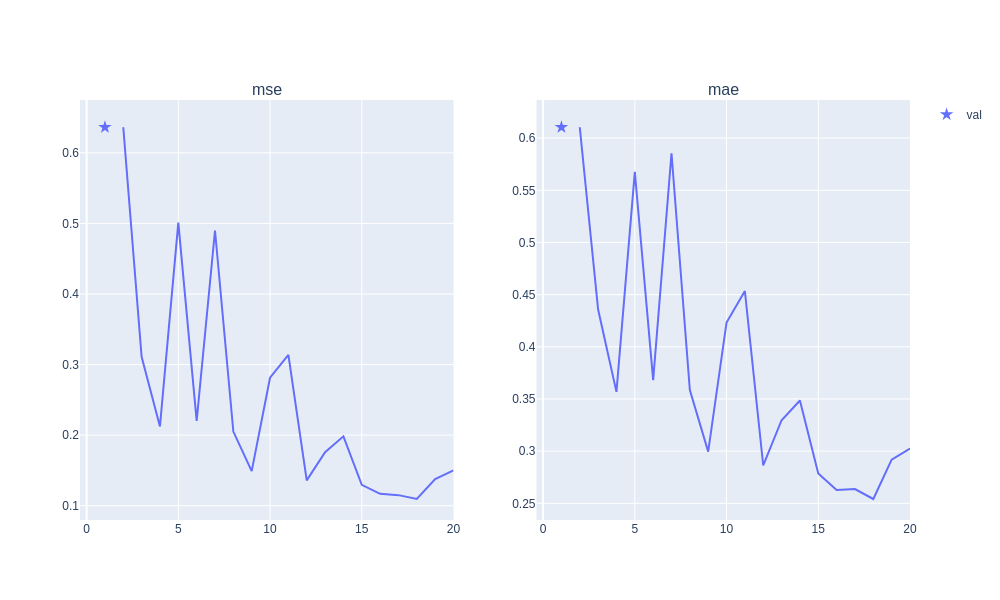

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [53]:
model = SalaryPredictor()
model.load_state_dict(torch.load("storage/sem_maxpool.pth"))
model = model.to(device)
model.eval();
print_metrics(model, data_val, device=device)

Mean square error: 0.07989
Mean absolute error: 0.21147


{'mse': 0.07988765102666534, 'mae': 0.21146893001593334}

In [54]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 
    
    model.eval()
    with torch.no_grad():
        *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token, device=device)).detach().cpu()
        
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [55]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [56]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [57]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [58]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 146645
Salary (gbp): tensor(18644.3516)


assistant manager

assistant manager business : st george dragon exeter location : exeter brand : vintage inns salary : **** **** live in : no working at vintage inns if you value individuality and charm as much as we do , working in a traditional country pub is going to suit you down to the ground . with assistant manager vacancies across our cosy rural pubs and restaurants , you can find the perfect environment to make the most of your talents . country dining with a modern twist join our team and you ’ ll be part of the warm , relaxed atmosphere you ’ d expect from a country inn with a contemporary flavour , while learning your trade in one of the most stimulating and rewarding environments in the business . what ’ s more every day at work will be in a perfect country retreat www . vintageinn . co . uk welcome to vintage inns in exeter st george dragon is special because its local charm that attracts office staff and ramblers , as well as diners and drinkers from clyst st . george and nearby UNK , UNK and clyst st . mary . UNK placed for the UNK arena show and exhibition venue , the st george dragon has an astonishing history , and offers a tall UNK or two . it ' s a pub with rooms too , so you can stay a while . as the assistant manager of a vintage inn you ’ ll be working in one of britain ’ s finest country pubs . this is a place in the heart of the countryside with cosy interiors retaining wonderful original features , simply dripping with individuality and style . people travel here from miles around for the superb seasonal food and fantastic service , so there ’ ll be no standing still for you and your team what you ’ ll do in this role your role is to deliver the ‘ country pub dream ’ to our guests – from the roaring fires in the winter , to the stunning gardens in the summer . it ’ s the little touches that make all the difference – flowers on the bar , tea lights on the tables , interesting displays and stylish merchandising . you ’ ll be attracted by the adrenaline rush of managing a busy pub and leading a team of talented individuals . as assistant manager , you ’ ll be ensuring that standards of food and service are consistently excellent you ’ ll be responsible for training and inspiring a large team first and last impressions count and it ’ ll be your job to ensure that guests leave with the right one you ’ ll be taking your first step on a management career ladder that ’ s limited only by your ambition you ’ ll be joining our awardwinning assistant manager programme what will make you perfect for the job ? ideally a minimum of 1 years previous experience in a similar role in a full service , partial fresh food business being able to recruit , develop and retain a large team of talented individuals having the passion and knowledge to talk confidently about fresh food , premium wines and cask ales being able to intuitively deliver those ‘ little touches ’ without needing a brand manual growing the business by using your initiative and ideas to drive local trade , for example , jazz nights , tasting parties or supporting local charities keen to work on the bar and floor and in the kitchen – being hands on and leading from the front the ambition to be a great manager of the future please be aware that this position will require you to hold a full driving licence and you must have continued and unlimited access to a vehicle . what we offer contributory pension scheme assistant manager bonus scheme – earn up to **** per annum private healthcare structured training programme 25 days ’ holiday apply for this assistant manager position now if you fancy a rewarding and challenging career where you can really go places . this job was originally posted as www . caterer . com / jobseeking / assistantmanager_job ****

Max pooling doesn't allow to focus on much words, so here is result for average pooling (note, that weight for description was changed from 10 to 20 for `i=36605`):

In [59]:
model = SalaryPredictor()
model.load_state_dict(torch.load("storage/sem_avgpool.pth"))
model.eval();

In [61]:
model.title_encoder[3] = nn.AdaptiveAvgPool1d(output_size=1)
model.description_encoder[3] = nn.AdaptiveAvgPool1d(output_size=1)
model.to(device)
print_metrics(model, data_val, device=device)

Mean square error: 0.10951
Mean absolute error: 0.25412


{'mse': 0.10951092958440577, 'mae': 0.2541189815949667}

In [64]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 20) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [63]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

Results yield much more colored words.

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

# Bottom

## static plots

In [49]:
from IPython.display import display

<a id="1_dest" href="#1_src">[back]</a> learning curves

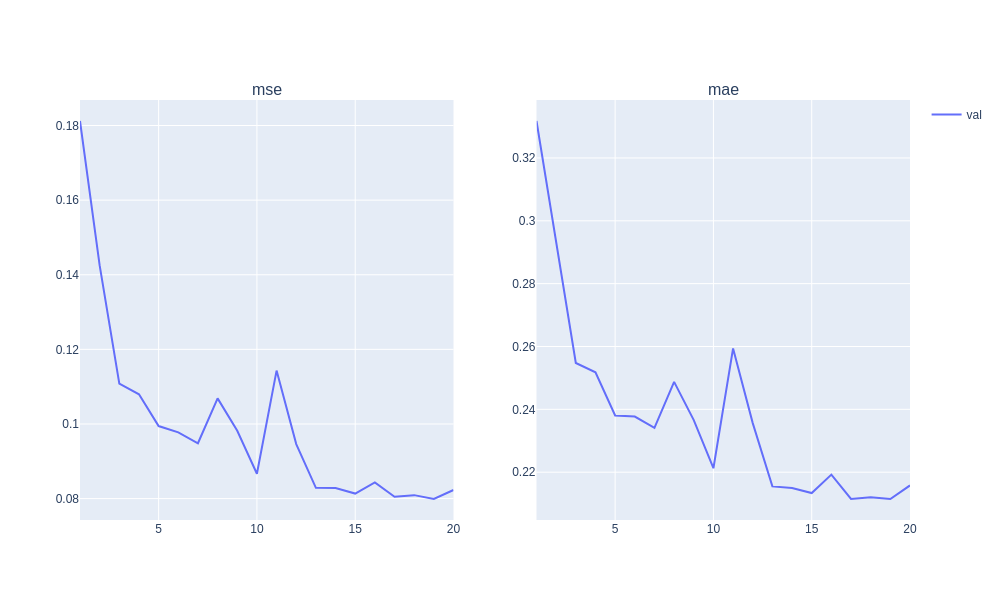

In [51]:
display(plotly_static(plotter.draw_no_widget()))

## additional code

In [ ]:
# %load plotter
import warnings
from dataclasses import dataclass, field
from math import ceil
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Image
from plotly.subplots import make_subplots
from tqdm.auto import tqdm


Report = dict[str, float]
@dataclass
class History:
    train: list[Report] = field(default_factory=list)
    val: list[Report] = field(default_factory=list)
    drop_query: str = 'phase != phase' # query to return none
    
    def push_epoch(self, *reports: tuple[Report, Report] | tuple[Report]) -> None:
        if len(reports) == 1:
            val_report, = reports
            train_report = {}
        else:
            train_report, val_report = reports
        self.train.append(train_report)
        self.val.append(val_report)
    
    def as_dfs(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        # return metrics as 2 DataFrames with additional epoch and phase (train / val) columns
        # for plotting
        
        df = pd.concat(map(pd.DataFrame, [self.train, self.val]),
                       keys=["train", "val"])\
                .reset_index(names=["phase", "epoch"])
        df.epoch += 1
        
        return df.query(f"not ({self.drop_query})"), df.query(self.drop_query)
    
    def as_df(self) -> pd.DataFrame:
        return self.as_dfs()[0]
    
    def __len__(self) -> int:
        return len(self.train)
    
    def range(self, max_epochs, stopper = None, do_tqdm = False):
        loop = range(max(max_epochs - len(self), 0))
        if do_tqdm:
            loop = tqdm(loop, desc="epoch")
            
        for i in loop:
            if stopper is not None and stopper():
                return
            yield i
        if stopper is not None:
            stopper()

@dataclass
class Plotter:
    metrics: list[str] = field(default_factory=list)
    titles: list[str] = field(default_factory=list)
    height: int = 600
    width: int = 1000
    plot_cols: int = 3
    path: Path | str | None = None
    bound_history: History | None = None
    # custom_range: dict[str, tuple[int, int]] = field(default_factory=dict)
    
    def __post_init__(self):
        if self.path is not None:
            self.path = Path(self.path)
            if self.path.exists():
                warnings.warn("File already exists!")
            
        self._inited = False
        if not self.titles:
            self.titles = self.metrics
        
        self.fig: plotly.graph_objs._figure.Figure
        self.traces = {}
        self.names = set()
        
    def init_canvas(self):
        plot_cols = min(self.plot_cols, len(self.metrics))
        plot_rows = max(1, ceil(len(self.metrics) / plot_cols))
        self.fig = go.FigureWidget(make_subplots(rows=plot_rows, cols=plot_cols, subplot_titles=self.titles))
        self.fig.update_layout(height=self.height, width=self.width, showlegend=True)
        display(self.fig)
    
    def display(self):
        display(self.fig)
    
    def plot(self, history: History | None = None):
        if history is None:
            history = self.bound_history
            assert history is not None
        
        df_kept, df_dropped = history.as_dfs()
        if not self._inited:
            if not self.metrics:
                self.metrics = self.titles = list(set(df_dropped.columns) - {"phase", "epoch"})
            self.init_canvas()
            self._inited = True
        
        for handle, df in ("kept", df_kept), ("dropped", df_dropped):
            for i, metric in enumerate(self.metrics):
                for trace in px.scatter(df.dropna(subset=metric),
                                        x="epoch", y=metric, color="phase")["data"]:
                    
                    if (handle, metric, trace.name) in self.traces:
                        _trace = self.traces[(handle, metric, trace.name)]
                        # avoid unneeded assignments, for they cause lags
                        if _trace.y.shape != trace.y.shape:
                            _trace.x, _trace.y = trace.x, trace.y
                        trace = _trace
                    else:
                        self.fig.append_trace(
                            trace,
                            row=i // self.plot_cols + 1, col=i % self.plot_cols + 1
                        )
                        self.traces[(handle, metric, trace.name)] = trace = self.fig.data[-1]
                        # remove duplicate legends
                        if trace.name in self.names:
                            trace.update(showlegend=False)
                        else:
                            self.names.add(trace.name)
                            
                    if trace.x.size > 1 and trace.mode != "lines" and handle != "dropped":
                        trace.mode = "lines"
                        
                    if handle == "dropped" and ("kept", metric, trace.name) in self.traces:
                        kept = self.traces[("kept", metric, trace.name)]
                        y = np.full_like(trace.y, kept.y[0])
                        
                        if not all(trace.y == y) or trace.marker["symbol"] != "star":
                            trace.customdata = trace.y[:, None]
                            trace.y = y
                            trace.hovertemplate = trace.hovertemplate.replace(
                                "%{y}",
                                "%{customdata[0]:.2f}" + f"({history.drop_query})"
                            )
                            trace.mode = "markers"
                            trace.marker["symbol"] = "star"
                            trace.marker["size"] = 10
                            trace.marker["color"] = kept.marker["color"]
                    
        if self.path is not None:
            self.fig.write_image(self.path)
            self.fig.write_html(str(self.path) + ".html")
            
    def draw_no_widget(self):
        return plotly.io.from_json(self.fig.to_json())

def plotly_static(fig: plotly.graph_objs._figure.Figure, format: str = "png") -> Image:
    return Image(fig.to_image(format=format))


In [ ]:
# %load magic
import ast
import inspect
from _ast import (
    Call,
    Expr,
    FunctionDef,
    Module,
    Name,
)
from collections import defaultdict
from itertools import count
from types import FunctionType, CodeType
from typing import Any, Iterable

from IPython import get_ipython
from IPython.core.magic import register_cell_magic
from IPython.display import clear_output, display
from ipywidgets import Output
from tqdm.auto import tqdm


class MyOutput(Output):
    def __init__(self):
        super().__init__()
        display(self)
        
class ReusableTqdm:
    def __init__(self):
        self.tqdm = tqdm([None])
    
    def __call__(self, iterable: Iterable, **kwargs):
        try:
            self.tqdm.total = len(iterable)
        except TypeError:
            self.tqdm.total = None
        
        for key, val in kwargs.items():
            setattr(self.tqdm, key, val)
        
        self.tqdm.reset()
        if self.tqdm.total is not None:
            self.tqdm.container.children[1].max = self.tqdm.total
        
        for entry in iterable:
            yield entry
            self.tqdm.update()
            self.tqdm.refresh()
    
_OUTPUTS = defaultdict(MyOutput)
_TQDMS = defaultdict(ReusableTqdm)

def _reprint(*args, _caller_id, **kwargs):
    if None in _caller_id:
        # function was called without magic applied to all levels
        return print(*args, **kwargs)    
    
    output = _OUTPUTS[_caller_id]

    with output:
        output.clear_output()
        print(*args, **kwargs)

def _retqdm(*args, _caller_id, **kwargs):
    if None in _caller_id:
        # function was called without magic applied to all levels
        yield from tqdm(*args, **kwargs)
        return
    
    tqdm_creator = _TQDMS[_caller_id]
    
    yield from tqdm_creator(*args, **kwargs)
    

###########################################################

reprintable_funcs = {"print", "tqdm"}

def get_expr_ast(line: str):
    res = ast.parse(line).body[0]
    return res.value if isinstance(res, Expr) else res

def copy_data(dest, src):
    ast.copy_location(dest, src)
    ast.fix_missing_locations(dest)

class PrintTransformer(ast.NodeTransformer):
    def __init__(self) -> None:
        self.count = count()
        super().__init__()

    def visit_Call(self, node: Call) -> Call:
        func = node.func
        if isinstance(func, Name) and func.id in reprintable_funcs:
            if func.id in ["print", "tqdm"]:
                node.func = get_expr_ast(f"reprint.{func.id}")
                copy_data(node.func, node)
            node.keywords.append(ast.keyword(
                arg="_caller_id",
                value=get_expr_ast(f"_caller_id + ({next(self.count)}, )")
            ))
            
            copy_data(node.keywords[-1], node)

        return super().generic_visit(node)
    
    def visit_Module(self, node: Module) -> Module:
        # crutch for module-level func callers
        node.body.insert(0, get_expr_ast(f'_caller_id = ()'))
        
        for statement in node.body:
            if isinstance(statement, FunctionDef):
                reprintable_funcs.add(statement.name)
                statement.args.kwonlyargs.append(ast.arg(arg="_caller_id"))
                statement.args.kw_defaults.append(get_expr_ast("(None,)"))
                
                copy_data(statement.args.kwonlyargs[-1], statement.args)
                copy_data(statement.args.kw_defaults[-1], statement.args)
                
        return super().generic_visit(node)

    def __eq__(self, other):
        return self is other


ipy = get_ipython()


@register_cell_magic
def reprint(f, cell = None):
    tr = PrintTransformer()
    if cell is not None:
        # magic call
        _OUTPUTS.clear()
        _TQDMS.clear()
        clear_output()
        ipy.ast_transformers.append(tr)
        ipy.run_cell(cell)
        if tr in ipy.ast_transformers:
            ipy.ast_transformers.remove(tr)
    else:
        # decorator call
        # https://devmessias.github.io/post/python_ast_metaprogramming_with_introspection_and_decorators/#creating-a-new-function-at-runtime
        source = inspect.getsource(f)
        source = "\n".join(line
                           for line in source.split("\n")
                           if not line.startswith("@reprint"))
        tree = ast.parse(source)
        tree = tr.visit(tree)
        code_obj = compile(tree, f.__code__.co_filename, 'exec')
        function_code = [c for c in code_obj.co_consts if isinstance(c, CodeType)][0]
        transformed_func = FunctionType(function_code, f.__globals__, argdefs=f.__defaults__)
        
        kw_default = (f.__kwdefaults__ or {}) | {"_caller_id" : (None,)}
        return lambda *args, **kwargs: transformed_func(*args, **(kw_default | kwargs))

reprint.print = _reprint
reprint.tqdm = _retqdm
    
def display_no_widgets(plotter):
    clear_output()
    display(plotter.draw_no_widget())
    print("\n".join(output.outputs[0]["text"] for output in _OUTPUTS.values() if output.outputs))


class SoftCtrlCTransformer(ast.NodeTransformer):
    def visit_Module(self, node: Module) -> Module:
        try_ = ast.parse("""
try:
    pass
except KeyboardInterrupt:
    print("interrupted by keyboard")
""")
        try_.body[0].body = node.body

        return super().generic_visit(try_)

    def __eq__(self, other):
        return self is other

@register_cell_magic
def soft_ctrl_c(_, cell):
    tr = SoftCtrlCTransformer()
    ipy.ast_transformers.append(tr)
    ipy.run_cell(cell)
    if tr in ipy.ast_transformers:
        ipy.ast_transformers.remove(tr)


In [ ]:
# %load torch_utils
from functools import wraps
from typing import TypeVar, Iterable, Hashable

import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

class Apply(nn.Module):
    def __init__(self, func, *func_args, **func_kwargs):
        super().__init__()
        self.func = func
        self.func_args = func_args
        self.func_kwargs = func_kwargs
    
    def forward(self, X):
        return self.func(X, *self.func_args, **self.func_kwargs)
    
Arr = TypeVar("Arr", torch.Tensor, np.array)

def normalize(x: Arr, dim: int = -1, ord: int | float | str= 2, eps: float = 1e-6) -> Arr:
    if isinstance(x, np.ndarray):
        norm = np.linalg.norm(x, ord=ord, axis=dim, keepdims=True)
    else:
        norm = x.norm(dim=dim, p=ord, keepdim=True)
    return x / (norm + eps)

def train_val_test_split(*arrays, val_size: float, test_size: float = 0, **kwargs):
    rets_train_val = train_test_split(*arrays, test_size=test_size + val_size, **kwargs)
    
    val_size_cond = val_size / (test_size + val_size)
    rets_val_test = train_test_split(*rets_train_val[1::2], train_size=val_size_cond, **kwargs)
    
    train, val, test = rets_train_val[::2], rets_val_test[::2], rets_val_test[1::2]
    
    return sum(zip(train, val, test), start=())

def device_default(f):
    @wraps(f)
    def inner(*args, device=None, **kwargs):
        if device is None:
            device = f.__globals__["device"]
        return f(*args, **kwargs, device=device)
    return inner

def map_idx(values: Iterable[Hashable]) -> dict[Hashable, int]:
    return {value : idx for idx, value in enumerate(values)}



In [ ]:
# %load train
from collections import defaultdict
from dataclasses import dataclass
from typing import Callable, Any
from warnings import warn

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

try:
    from magic import reprint
except ImportError:
    warn("Couldn't load magic!")
    reprint = lambda t: t

__all__ = ["loopa", "ACC_METRIC", "EarlyStopper"]

ListOfMetrics = list[
    str |
    tuple[
        str,
        Callable[[torch.Tensor, torch.Tensor], Any], # metric calculation
        Callable[[list[Any]], float],                # metric aggregation
    ]
]

def to(X, device):
    if isinstance(X, dict):
        for key, val in X.items():
            X[key] = val.to(device)
        return X
    if isinstance(X, torch.Tensor):
        return X.to(device)
    raise RuntimeError(f"Incorrect type {type(X)}")

@reprint
def _loopa(*, model: nn.Module, dataloader: DataLoader, device: str,
           loss_fn, optim, metrics: ListOfMetrics,
           is_train: bool = True, accum_grad: int = 1):
    
    metric_lists = defaultdict(list)
    _metrics = []
    for metric in metrics:
        if isinstance(metric, str):
            if metric not in METRICS:
                raise RuntimeError(f"couldn't find metric: {metric}")
            _metrics.append((metric, *METRICS[metric]))
        else:
            _metrics.append(metric)
    metrics = _metrics
            
    if is_train:
        optim.zero_grad()
        
    for i, (X, y) in enumerate(tqdm(dataloader, desc="train phase" if is_train else "val phase")):
        X, y = to(X, device), to(y, device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y) / accum_grad
        
        if is_train:
            loss.backward()
            if not (i + 1) % accum_grad:
                optim.step()
                optim.zero_grad()
            
        with torch.no_grad():
            for metric, fn, _ in metrics:
                if metric == "loss":
                    metric_lists["loss"].append(loss.item() * accum_grad)
                else:
                    metric_lists[metric].append(fn(y_pred, y))
    
    if is_train and (i + 1) % accum_grad:
        # optim.step()
        optim.zero_grad()
    
    metric_results = {}
    for key, _, agg in metrics:
        metric_results[key] = agg(metric_lists[key])
    
    return metric_results

@reprint
def loopa(model: nn.Module, dataloader: DataLoader, *, device: str,
           loss_fn=None, optim=None, metrics: ListOfMetrics,
           is_train: bool = True, accum_grad: int = 1):
    if is_train:
        model.train()
        return _loopa(model=model, dataloader=dataloader, device=device,
                      loss_fn=loss_fn, optim=optim, metrics=metrics, accum_grad=accum_grad,
                      is_train=is_train)
    
    with torch.no_grad():
        model.eval()
        ret = _loopa(model=model, dataloader=dataloader, device=device,
                     loss_fn=loss_fn, optim=optim, metrics=metrics, accum_grad=accum_grad,
                     is_train=is_train)
        model.train()
        return ret

##########################################################################

try:
    from plotter import History
except ImportError:
    pass

@dataclass
class EarlyStopper:
    model: nn.Module
    save_path: str
    bound_history: "History"
    loss: str = "loss"
    patience: int | None = 3
    min_delta: float = 0
    
    def __post_init__(self):
        self.best_epoch: int = -1 if not len(self.bound_history) else self.get_losses().argmin() + 1
        self.best_loss = np.inf if not len(self.bound_history) else self.get_losses().min()
        
    def __str__(self):
        if self.loss.startswith("-"):
            metric = self.loss[1:]
            sign = -1
        else:
            metric = self.loss
            sign = 1
        return f"based on metric: {metric}, best epoch: {self.best_epoch}, best value: {sign * self.best_loss}"
    
    def get_losses(self):
        if self.loss.startswith("-"):
            metric = self.loss[1:]
            sign = -1
        else:
            metric = self.loss
            sign = 1
        return np.array([sign * res[metric]
                         for res in self.bound_history.val])
    
    def __call__(self):
        """
        saves model on improvement
        returns True if training should stop else False
        """ 
        losses = self.get_losses()
        if not len(losses):
            return False
        
        if losses[-1] <= self.best_loss:
            self.best_loss = losses[-1]
            self.best_epoch = len(self.bound_history)
            torch.save(self.model.state_dict(), self.save_path)
            return False
        return len(losses) > self.patience and np.all(losses[-self.patience:] > self.best_loss + self.min_delta)

def mean_metric(sum_of_metrics_func: Callable[[torch.Tensor, torch.Tensor], float | torch.Tensor]):
    # ! if return is torch.Tensor, it has to be a scalar
    collector = lambda y_pred, y_true: (sum_of_metrics_func(y_pred, y_true), len(y_true))
    def aggregator(results):
        correct, total = map(sum, zip(*results))
        ret = correct / total
        return ret.item() if isinstance(ret, torch.Tensor) else ret
    return collector, aggregator

METRICS = {
    "loss": [None, np.mean],
    "acc": mean_metric(lambda y_pred, y_true: (y_pred.argmax(-1) == y_true).sum()),
}
